In [271]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import statsmodels.tsa.api as smt

In [272]:
df = pd.read_csv("../../Datasets/Bouletta/EtsySoldOrderItems2020-2021-2022.csv")

In [273]:
df.dropna(inplace=True)

In [274]:
df.head(5)

,Item Model,Quantity,Price,Coupon Code,Ship Country,Season,Month,Year,Color
0,4,1,33.50,1,1,0,12,2020,2.0
1,1,1,39.00,1,1,0,12,2020,1.0
2,5,1,41.50,1,1,0,12,2020,1.0
3,1,1,46.50,1,1,0,12,2020,1.0
4,7,1,39.75,1,1,0,12,2020,0.0


In [275]:
# create a new column 'Date' based on 'Month' and 'Year'
df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')

In [276]:
df['Total Profits'] = df['Quantity'] * df['Price']

In [277]:
df.to_csv('../../Datasets/Bouletta/train.csv')

In [278]:
def monthly_sales(data):
    monthly_data = data.copy()
    monthly_data = monthly_data.groupby('date')['Total Profits'].sum().reset_index()
    monthly_data.date = pd.to_datetime(monthly_data.date)
    return monthly_data

In [279]:
monthly_df = monthly_sales(df)
monthly_df.head()

,date,Total Profits
0,2020-01-01,1361.61
1,2020-02-01,1039.52
2,2020-03-01,987.36
3,2020-04-01,2111.57
4,2020-05-01,3258.21


In [280]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red',\
                 label='Mean Sales')   
    ax.set(xlabel = "date",ylabel = "Total Profits",title = title)
    sns.despine()

C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


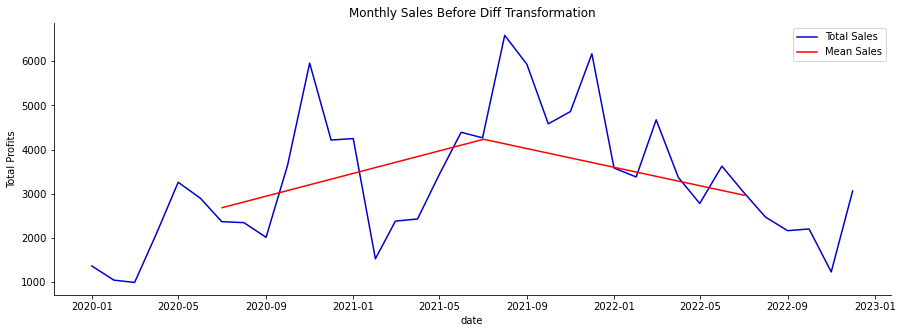

In [281]:
time_plot(monthly_df, 'date', 'Total Profits', 'Monthly Sales Before Diff Transformation')

In [282]:
def get_diff(data):
    data['sales_diff'] = data["Total Profits"].diff()
    data = data.dropna()
    
    data.to_csv('../../Datasets/Bouletta/stationary_df.csv')
    return data

In [283]:
stationary_df = get_diff(monthly_df)

C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


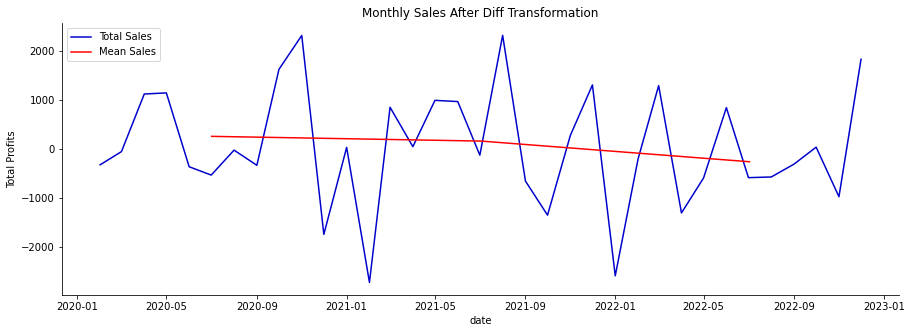

In [284]:
time_plot(stationary_df, 'date', 'sales_diff', 'Monthly Sales After Diff Transformation')

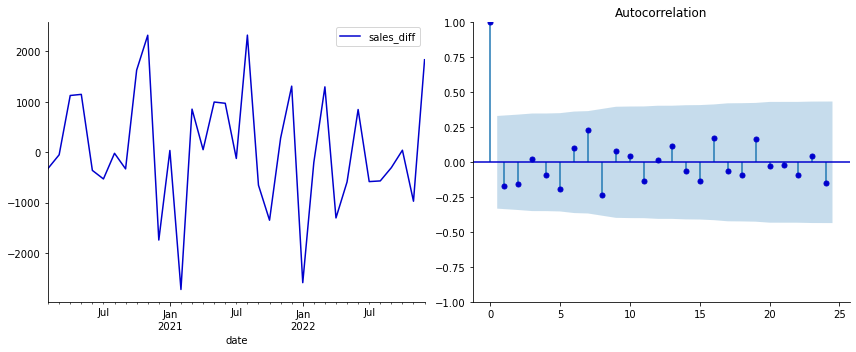

In [285]:
def plots(data, lags=None):
    
    # Convert dataframe to datetime index
    dt_data = data.set_index('date').drop('Total Profits', axis=1)
    dt_data.dropna(axis=0)
    
    layout = (1, 2)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
#     pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(12, 5), color='mediumblue')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
#     smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()

plots(stationary_df, lags=24);

***Regressive Modeling***

In [286]:
#create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    supervised_df.to_csv('../../Datasets/Bouletta/model_df.csv', index=False)
    
    return supervised_df

In [287]:
model_df = generate_supervised(stationary_df)

In [288]:
model_df

,date,Total Profits,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2021-02-01,1523.74,-2724.55,33.46,-1743.50,2319.86,1627.87,-332.04,-22.29,-531.44,-361.84,1146.64,1124.21,-52.16,-322.09
1,2021-03-01,2377.14,853.40,-2724.55,33.46,-1743.50,2319.86,1627.87,-332.04,-22.29,-531.44,-361.84,1146.64,1124.21,-52.16
2,2021-04-01,2426.04,48.90,853.40,-2724.55,33.46,-1743.50,2319.86,1627.87,-332.04,-22.29,-531.44,-361.84,1146.64,1124.21
3,2021-05-01,3420.63,994.59,48.90,853.40,-2724.55,33.46,-1743.50,2319.86,1627.87,-332.04,-22.29,-531.44,-361.84,1146.64
4,2021-06-01,4390.43,969.80,994.59,48.90,853.40,-2724.55,33.46,-1743.50,2319.86,1627.87,-332.04,-22.29,-531.44,-361.84
5,2021-07-01,4265.53,-124.90,969.80,994.59,48.90,853.40,-2724.55,33.46,-1743.50,2319.86,1627.87,-332.04,-22.29,-531.44
6,2021-08-01,6587.68,2322.15,-124.90,969.80,994.59,48.90,853.40,-2724.55,33.46,-1743.50,2319.86,1627.87,-332.04,-22.29
7,2021-09-01,5932.61,-655.07,2322.15,-124.90,969.80,994.59,48.90,853.40,-2724.55,33.46,-1743.50,2319.86,1627.87,-332.04
8,2021-10-01,4582.69,-1349.92,-655.07,2322.15,-124.90,969.80,994.59,48.90,853.40,-2724.55,33.46,-1743.50,2319.86,1627.87
9,2021-11-01,4860.97,278.28,-1349.92,-655.07,2322.15,-124.90,969.80,994.59,48.90,853.40,-2724.55,33.46,-1743.50,2319.86


***ARIMA Modeling***

In [289]:
def generate_arima_data(data):
    dt_data = data.set_index('date').drop('Total Profits', axis=1)
    dt_data.dropna(axis=0)
    
    dt_data.to_csv('../../Datasets/Bouletta/arima_df.csv')
    
    return dt_data

In [290]:
datetime_df = generate_arima_data(stationary_df)

In [291]:
datetime_df

,sales_diff
date,
2020-02-01,-322.09
2020-03-01,-52.16
2020-04-01,1124.21
2020-05-01,1146.64
2020-06-01,-361.84
2020-07-01,-531.44
2020-08-01,-22.29
2020-09-01,-332.04
2020-10-01,1627.87
